In [ ]:
# importing all the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors


from scipy.signal import welch, correlate, find_peaks
from scipy import stats
from scipy.stats import linregress
from scipy.optimize import curve_fit

In [2]:
from functions import *
from generic_plotting import *

#%autoreload 1

In [ ]:

# I will have a set of functions which can work independently thne the pulsar class will be used to  
# call these functions and do the analysis on the pulsar data file.


class PulsarDataFile:
    # No import needed; use static methods directly from Fn_1ch, e.g., Fn_1ch.compute_channel_intensity_matrix

    def __init__(self, file_path, data_type=None, channel_names = None,center_freq_MHZ = 326.5,bandwidth_MHZ = 16.5 ,n_channels=2,block_size=512, avg_blocks=60, sample_rate=33e6):
        self.file_path = file_path
        self.data_type = data_type

        self.n_channels = n_channels
        self.raw_data = None
        #self.intensity_matrix_ch_s = None
        self.channel_names = channel_names        
        self.block_size = block_size
        self.avg_blocks = avg_blocks
        self.sample_rate = sample_rate  # in Hz
        self.intensity_matrix_ch_s = np.array([])
        self.dedispersed_ch_s = np.array([])
        self.center_freq_MHZ = center_freq_MHZ
        self.bandwidth_MHZ = bandwidth_MHZ
        self.pulseperiod_ms = None
        self.dedispersion_measure = None


        print(vars(self))

        self.load_data()  # Automatically load data upon object creation

        if self.channel_names == None or self.n_channels != len(self.channel_names):
            print("No of given channels names and in data didn't match")
            self.channel_names = [f"ch{i}" for i in range(0, self.n_channels )]
        
        # if self.n_channels != n_channels:
        #     print("No of given channels and in data didnt match")
        #     self.intensity_matrix_ch_s = np.zeros(self.n_channels)
        #self.intensity_matrix_ch_s = None


    def load_data(self):
        if self.data_type == 'ascii':
            self.raw_data = np.loadtxt(self.file_path)
        elif self.data_type == 'binary':
            self.raw_data = np.fromfile(self.file_path, dtype=np.int32).reshape(-1, self.n_channels)
            #self.raw_data = temp_data[~np.isnan(temp_data).any(axis=1)]
        else:
            raise ValueError("Unsupported data type. Use 'ascii' or 'binary'.")

        print(f"Given Data is of ndim : {self.raw_data.ndim} . shape : {self.raw_data.shape[1]}")
        self.n_channels = self.raw_data.shape[1]

    def compute_intensity_matrix(self):
        if self.raw_data is None or self.n_channels is None:
            raise ValueError("Data not loaded. Please call load_data() first.")
        Intensity_Matrix = []
        for i in range(self.n_channels):
            channel_data = self.raw_data[:, i]
            Intensity_Matrix.append(compute_channel_intensity_matrix(
                channel_data, self.block_size, self.avg_blocks, self.sample_rate
            ))
        self.intensity_matrix_ch_s = Intensity_Matrix
        self.dedispersed_ch_s = np.empty_like(Intensity_Matrix)

    # def Auto_dedisperse(self,channel,nPeaks,to_plot,dm_min, dm_max):
    #     matrix = self.intensity_matrix_ch_s[channel]
    #     center_freq_MHZ = self.center_freq_MHZ
    #     bandwidth_MHZ = self.bandwidth_MHZ
    #     sample_rate = self.sample_rate
    #     block_size = self.block_size
    #     avg_blocks = self.avg_blocks
    #     Npeaks = nPeaks
    #     pulseperiod_ms = self.pulseperiod_ms
        
    #     dm, _ = find_best_dm(matrix, center_freq_MHZ,bandwidth_MHZ, sample_rate, block_size, avg_blocks,Npeaks,pulseperiod_ms, to_plot, dm_min, dm_max, tol=1)
    #     self.dedispersion_measure = dm

    def Manual_dedisperse(self,channel,DM):
        matrix = self.intensity_matrix_ch_s[channel]
        dedispersed = dedisperse(matrix, DM,block_size=self.block_size, avg_blocks=self.avg_blocks
                    , sample_rate=self.sample_rate , bandwidth_MHZ = self.bandwidth_MHZ ,center_freq_MHZ = self.center_freq_MHZ)
        self.dedispersed_ch_s[channel] = dedispersed
        self.dedispersion_measure = DM

    def gaussian(self, x, a, mu, sigma, c):
        return a * np.exp(-(x - mu)**2 / (2 * sigma**2)) + c

    def fit_multiple_gaussians(self, profile, num_peaks=10, distance=15, width=(5, 10), to_plot=False):
        peaks, _ = find_peaks(profile, distance=distance, width=width)
        peaks = peaks[:num_peaks]
        sigmas = []

        if to_plot:
            plt.figure(figsize=(10, 4))
            plt.plot(profile, label='Profile')

        for peak in peaks:
            try:
                x = np.arange(peak - 30, peak + 30)
                x = x[(x >= 0) & (x < len(profile))]
                y = profile[x]
                p0 = [np.max(y), peak, 10, np.median(profile)]
                popt, _ = curve_fit(self.gaussian, x, y, p0=p0)
                sigmas.append(abs(popt[2]))
                if to_plot:
                    plt.plot(x, self.gaussian(x, *popt), '--', label=f'Fit (peak {peak})')
            except Exception:
                continue

        if to_plot:
            plt.scatter(peaks, profile[peaks], color='red', zorder=5, label='Peaks')
            plt.legend()
            plt.title('Gaussian Fits to Profile Peaks')
            plt.xlabel('Sample')
            plt.ylabel('Intensity')
            plt.tight_layout()
            plt.show()

        return np.mean(sigmas) if sigmas else np.inf

    def sharpness_score(self, matrix, to_plot=False):
        profile = matrix.sum(axis=1)
        t_bin_ms = self.block_size / self.sample_rate * 1000  # sample duration in ms
        if self.pulseperiod_ms is None:
            raise ValueError("pulseperiod_ms is not set in the class.")

        distance = int(self.pulseperiod_ms / t_bin_ms * 0.7)
        width = (
            int(self.pulseperiod_ms / t_bin_ms * 0.1),
            int(self.pulseperiod_ms / t_bin_ms * 0.5)
        )
        return -self.fit_multiple_gaussians(profile, num_peaks=10, distance=distance, width=width, to_plot=to_plot)

    def dedisperse_matrix(self, matrix, DM):
        return dedisperse(
            matrix, DM,
            block_size=self.block_size,
            avg_blocks=self.avg_blocks,
            sample_rate=self.sample_rate,
            bandwidth_MHZ=self.bandwidth_MHZ,
            center_freq_MHZ=self.center_freq_MHZ
        )

    def find_best_dm(self, matrix, dm_min=0, dm_max=100, tol=1, to_plot=False):
        def objective(dm):
            dedispersed = self.dedisperse_matrix(matrix, dm)
            score = self.sharpness_score(dedispersed, to_plot=False)
            print(f"DM = {dm:.2f}  ; Score = {score:.3f}")
            return score

        result = minimize_scalar(objective, bounds=(dm_min, dm_max), method='bounded', options={'xatol': tol})
        print(result)
        return result.x, -result.fun

    def Auto_dedisperse(self, channel, dm_min=0, dm_max=100, to_plot=False):
        matrix = self.intensity_matrix_ch_s[channel]

        best_dm, score = self.find_best_dm(matrix, dm_min=dm_min, dm_max=dm_max, to_plot=to_plot)
        self.dedispersion_measure = best_dm

        dedispersed = self.dedisperse_matrix(matrix, best_dm)
        self.dedispersed_ch_s[channel] = dedispersed

        if to_plot:
            profile = dedispersed.sum(axis=1)
            self.sharpness_score(dedispersed, to_plot=True)
        
        


In [52]:
# Initialize and run the analysis
long_data = "/home/ashwin-ubuntu/GIT/Vela_Data_analysis/Vela_Data/ch00_B0833-45_20150612_191438_011_1"
short_data = "/home/ashwin-ubuntu/GIT/Vela_Data_analysis/Analysis/vela_chunks/chunk_0001.txt"

vela = PulsarDataFile(long_data, data_type='ascii')

vela.compute_intensity_matrix()



{'file_path': '/home/ashwin-ubuntu/GIT/Vela_Data_analysis/Vela_Data/ch00_B0833-45_20150612_191438_011_1', 'data_type': 'ascii', 'n_channels': 2, 'raw_data': None, 'channel_names': None, 'block_size': 512, 'avg_blocks': 60, 'sample_rate': 33000000.0, 'intensity_matrix_ch_s': array([], dtype=float64), 'dedispersed_ch_s': array([], dtype=float64), 'center_freq_MHZ': 326.5, 'bandwidth_MHZ': 16.5, 'pulseperiod_ms': None, 'dedispersion_measure': None}
Given Data is of ndim : 2 . shape : 2
No of given channels names and in data didn't match


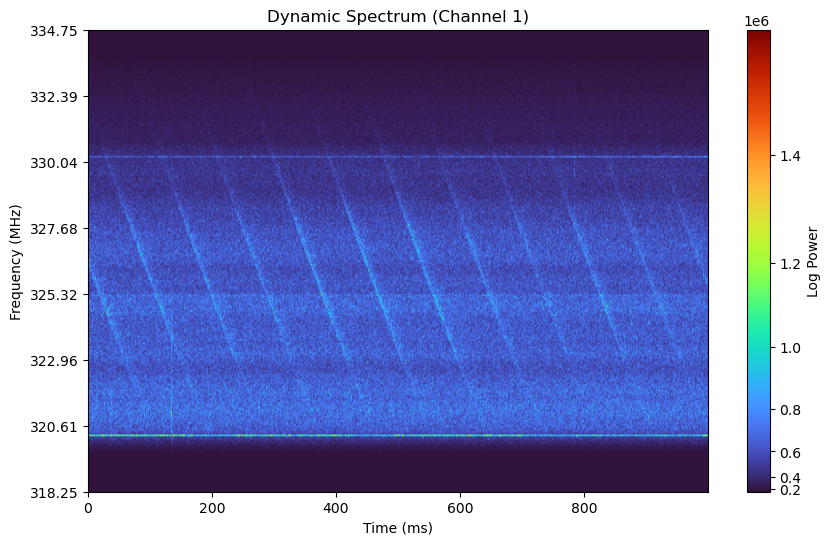

In [57]:
plot_intensity_matrix(vela,channel = 1)

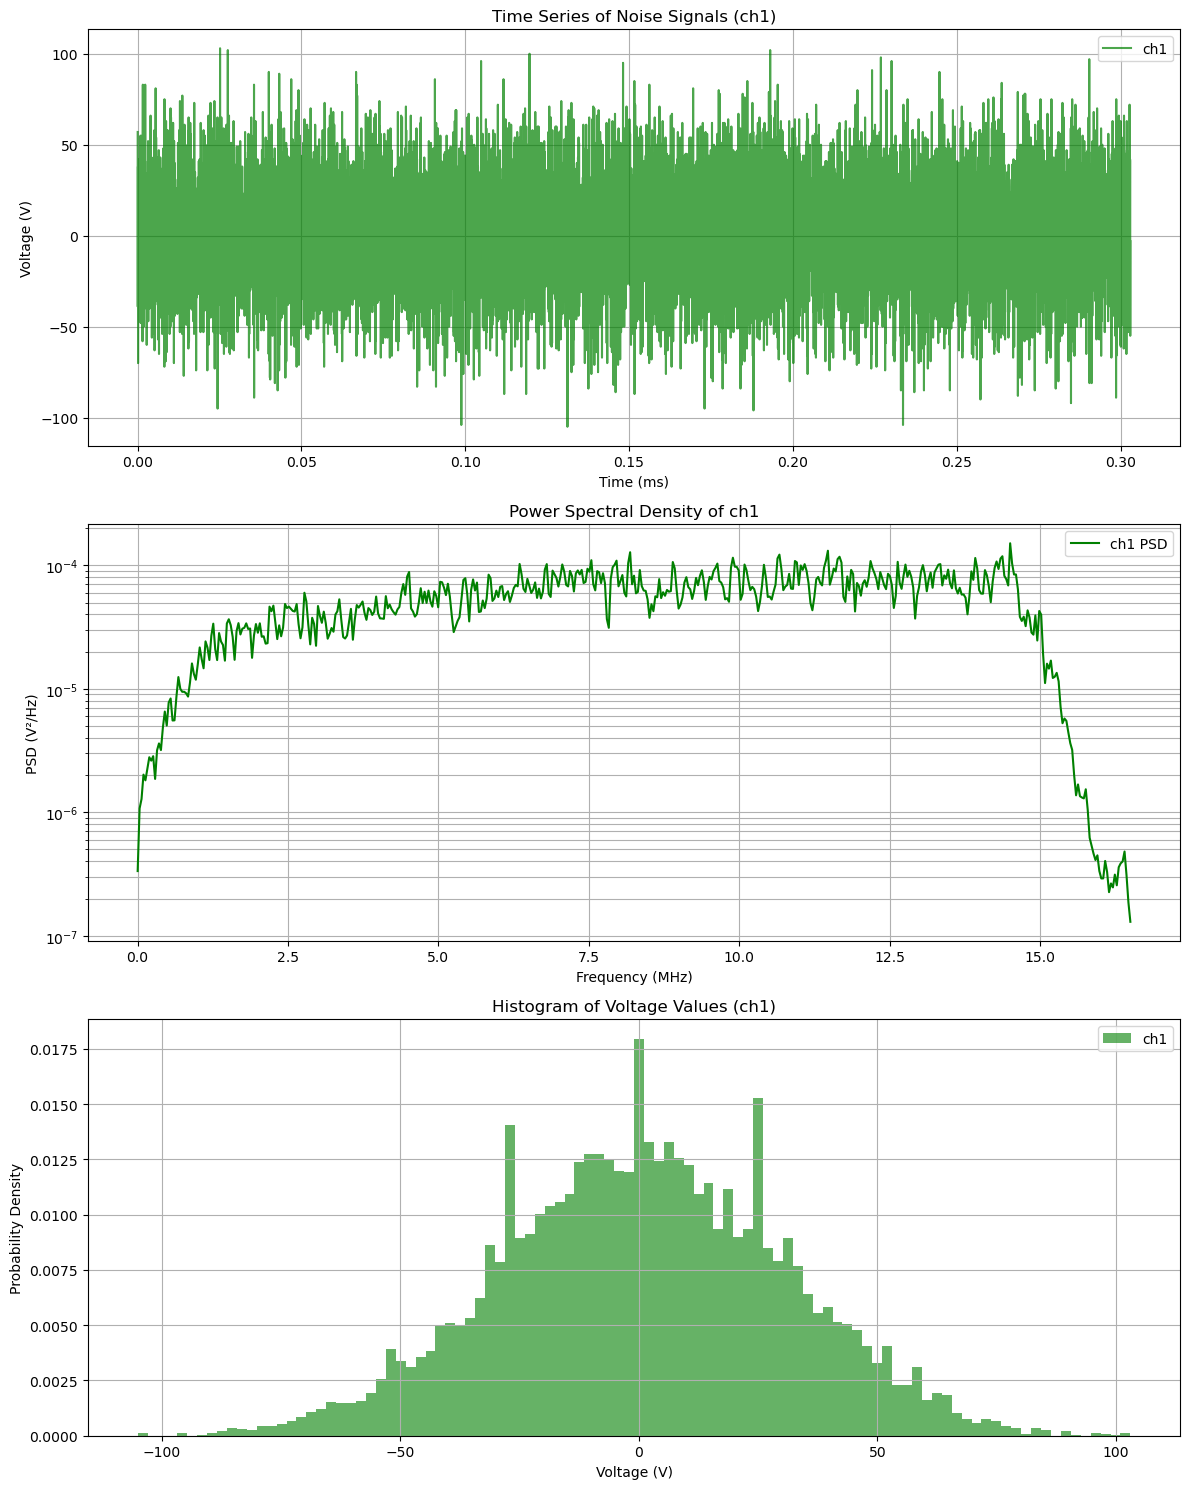

Top 3 peak positions (ms): [ 89.36727273 178.73454545 268.10181818]


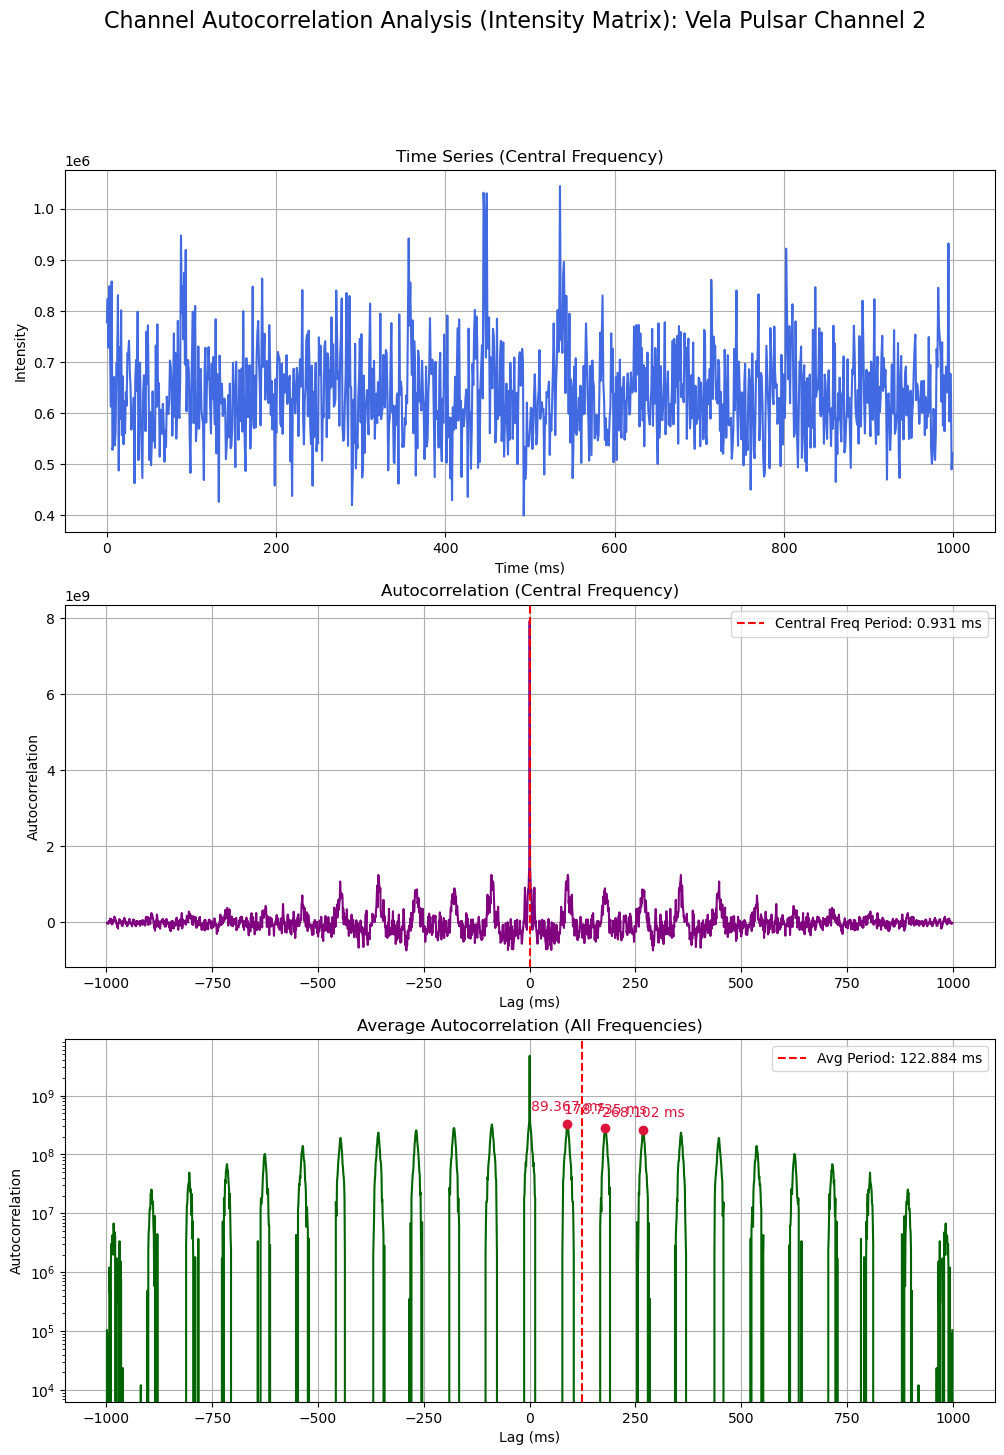

[-0.99886545 -0.99793455 -0.99700364 ...  0.99700364  0.99793455
  0.99886545]
Autocorr peak lags (ms): [ 89.36727273 178.73454545 268.10181818 357.46909091 446.83636364]
Period candidates (ms): [89.36727273 89.36727273 89.36727273 89.36727273 89.36727273]
Estimated pulsar period: 89.367 ms


In [6]:
Plot_characterstics(vela,channel=1)
analyze_autocorrelation(vela,channel=1, label="Vela Pulsar Channel 2")


Top 3 peak positions (ms): [ 89.36727273 178.73454545 268.10181818]


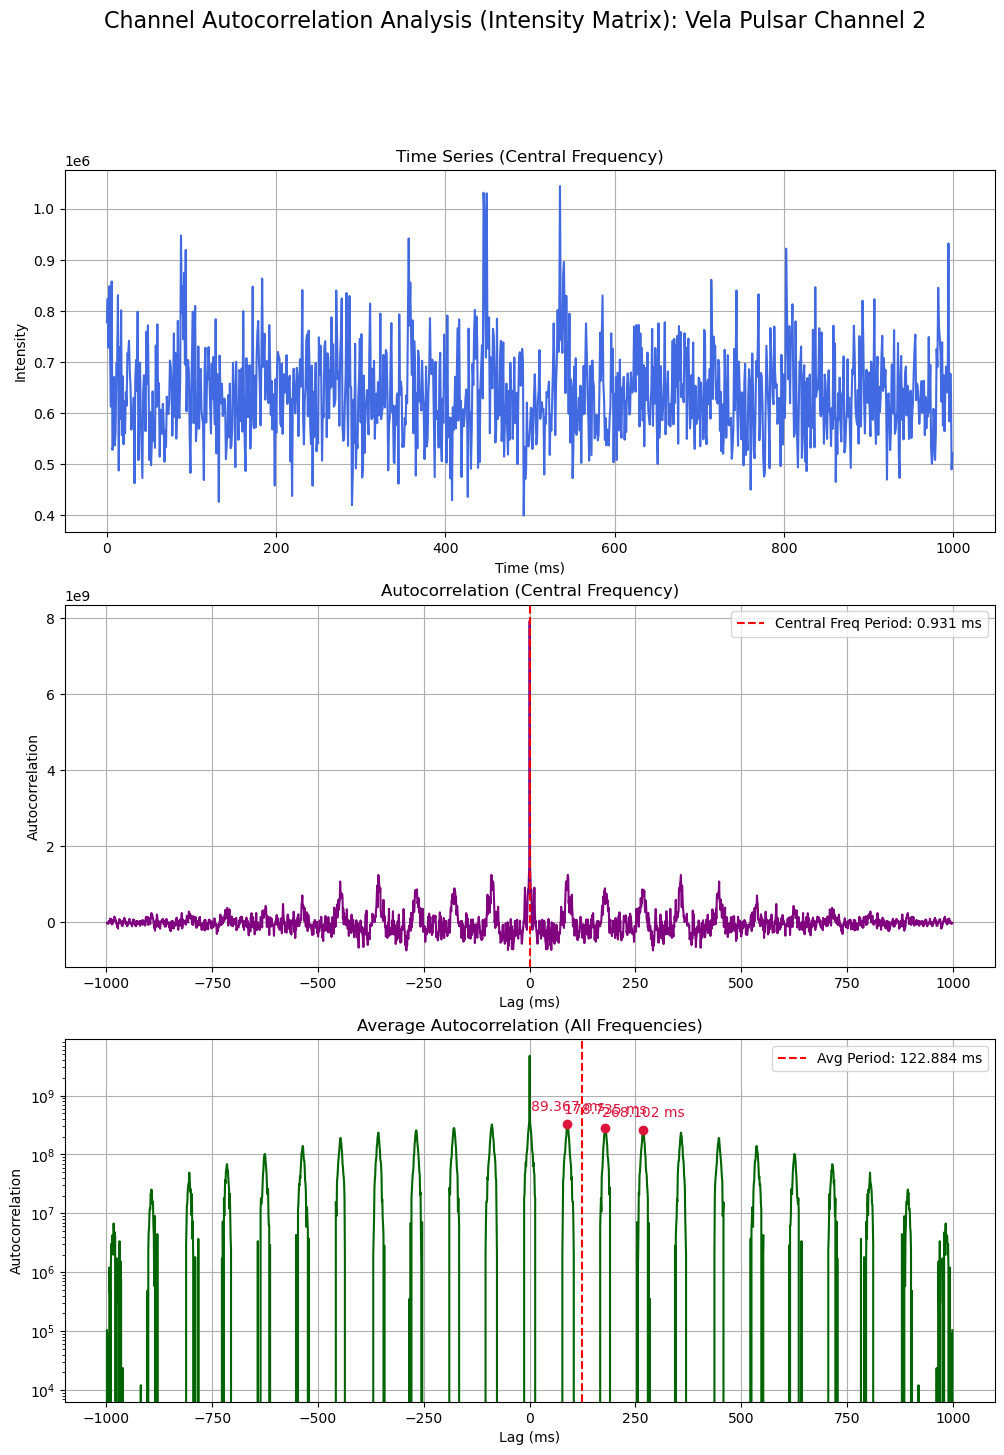

[-0.99886545 -0.99793455 -0.99700364 ...  0.99700364  0.99793455
  0.99886545]
Autocorr peak lags (ms): [ 89.36727273 178.73454545 268.10181818 357.46909091 446.83636364]
Period candidates (ms): [89.36727273 89.36727273 89.36727273 89.36727273 89.36727273]
Estimated pulsar period: 89.367 ms


In [7]:
analyze_autocorrelation(vela,channel=1, label="Vela Pulsar Channel 2")


In [54]:
vela.pulseperiod_ms = 89.3673

DM = 57.64  ; Score = -9.849
DM = 62.36  ; Score = -7.664
DM = 54.72  ; Score = -13.194
DM = 52.92  ; Score = -17.912
DM = 51.80  ; Score = -12.529
DM = 53.31  ; Score = -17.078
DM = 52.49  ; Score = -12.951
 message: Solution found.
 success: True
  status: 0
     fun: -17.91195540681296
       x: 52.91796067500631
     nit: 7
    nfev: 7


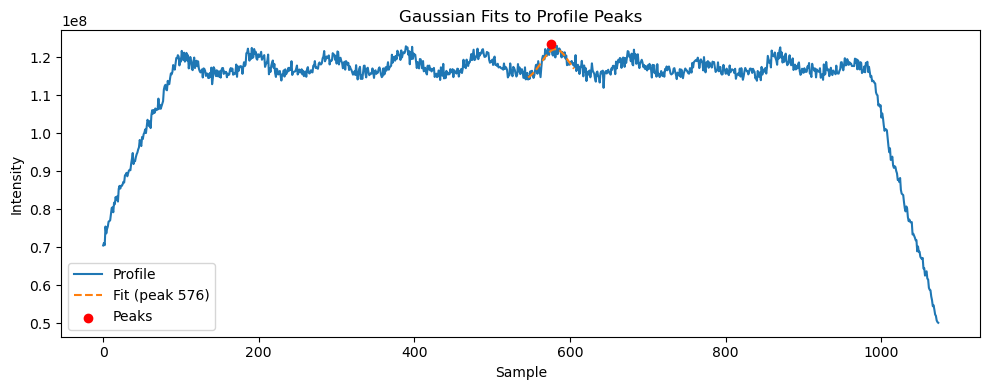

In [58]:
channel = 1
nPeaks = 10
to_plot = True

vela.Auto_dedisperse(1,50,70,True)

In [15]:

def dedisperse_matrix(matrix, DM,block_size, avg_blocks , sample_rate):

    """
    Dedisperse intensity matrix using cold plasma dispersion delay.
    DM is in pc/cm^3 should be DM=67.8 for vela
    """

    n_time, n_freq = matrix.shape
    #print(matrix.shape)

    # # Generate frequency array for each channel
    bandwidth = 16.5 /1000 # MHz to GHz
    center_freq = 326.5 / 1000 # MHz to GHz
    freq_array = np.linspace(center_freq - bandwidth / 2, center_freq + bandwidth / 2, n_freq)


    # Reference frequency (earliest arrival): highest frequency
    f_ref = freq_array[len(freq_array)//2]

    # Calculate delay in microseconds for each frequency channel
    delays_ms = 4.15 * DM * (1 / freq_array**2 - 1 / f_ref**2)  # in ms
    #delays_s = delays_ms  / 1000  # to Sec


    # # Time bin duration (microseconds per row)
    t_bin =  avg_blocks * block_size / sample_rate * 1000 # in mili Sec
    #print( "Time bin",t_bin)

    delay_bins = (delays_ms / t_bin).astype(int)
    
    # # Initialize dedispersed matrix
    dedispersed = np.zeros_like(matrix)

    for i in range(n_freq):
        shift = delay_bins[i]
        dedispersed[:, i] = np.roll(matrix[:, i], shift)
        if shift > 0 :
            dedispersed[:abs(shift),i] = 0
        elif shift < 0:
            dedispersed[shift:,i] = 0

    return dedispersed
    

sample_rate=33e6
block_size=512
avg_blocks=60
pulseperiod = 90 # ms
t_bin_ms = (block_size * avg_blocks / sample_rate) * 1e3


def sharpness_score(matrix):
    profile = matrix.sum(axis=1)
    distance = int(pulseperiod / t_bin_ms  * 0.7 ) 
    width=( int(pulseperiod / t_bin_ms * 0.1) , int(pulseperiod / t_bin_ms * 0.5 ))
    Peeks  = 10
    return -fit_multiple_gaussians(profile,num_peaks = Peeks,distance=distance,width=width)  # Lower sigma → better alignment

def find_best_dm(matrix, freqs, sample_rate, block_size, avg_blocks,
                 dm_min=0, dm_max=100, tol=1):

    def objective(dm):
        dedispersed = dedisperse_matrix(matrix, dm, block_size, avg_blocks, sample_rate)

        print(f"DM = {dm}  ; score = {sharpness_score(dedispersed)}")
        #plot_intensity_matrix(dedisperse_matrix(matrix, dm, block_size, avg_blocks , sample_rate), block_size, avg_blocks , sample_rate,gamma=2.5)

        return sharpness_score(dedispersed)

    result = minimize_scalar(objective, bounds=(dm_min, dm_max), method='bounded', options={'xatol': tol})
    print(result)
    return result.x, -result.fun



def gaussian(x, a, mu, sigma, c):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2)) + c

def fit_multiple_gaussians(profile, num_peaks=11, distance=15, width=(5, 100)):
    peaks, _ = find_peaks(profile, distance=distance, width=width)
    peaks = peaks[:num_peaks]
    sigmas = []

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 4))
    plt.plot(profile, label='Profile')
    x_full = np.arange(len(profile))

    for peak in peaks:
        try:
            x = np.arange(peak - 30, peak + 30)
            x = x[(x >= 0) & (x < len(profile))]
            y = profile[x]
            p0 = [np.max(y), peak, 10, np.median(profile)]
            popt, _ = curve_fit(gaussian, x, y, p0=p0)
            sigmas.append(abs(popt[2]))
            plt.plot(x, gaussian(x, *popt), '--', label=f'Gaussian fit (peak {peak})')
        except Exception as e:
            continue

    plt.scatter(peaks, profile[peaks], color='red', zorder=5, label='Peaks')
    plt.legend()
    plt.title('Gaussian Fits to Profile Peaks')
    plt.xlabel('Sample')
    plt.ylabel('Intensity')
    plt.tight_layout()
    plt.show()

    return np.mean(sigmas) if sigmas else np.inf




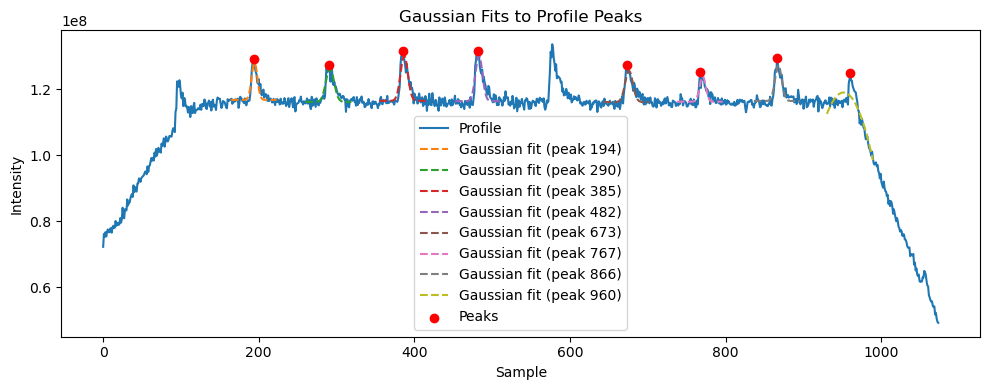

DM = 66.90983005625053  ; score = -181.44901737524495


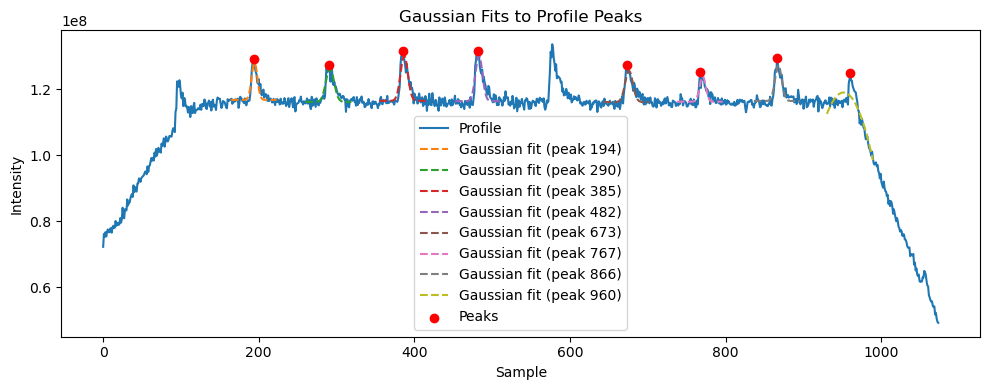

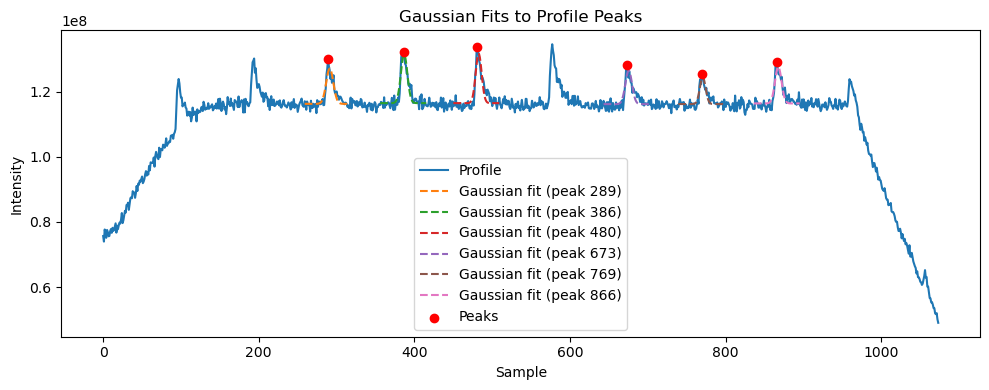

DM = 68.09016994374947  ; score = -4.118433341643022


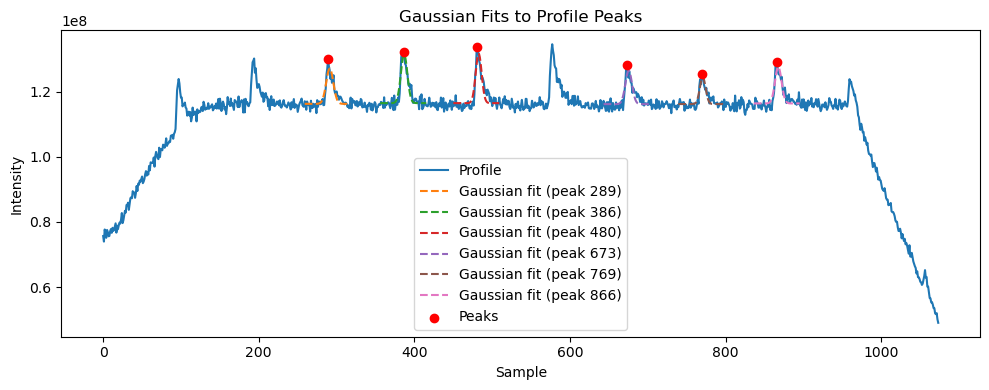

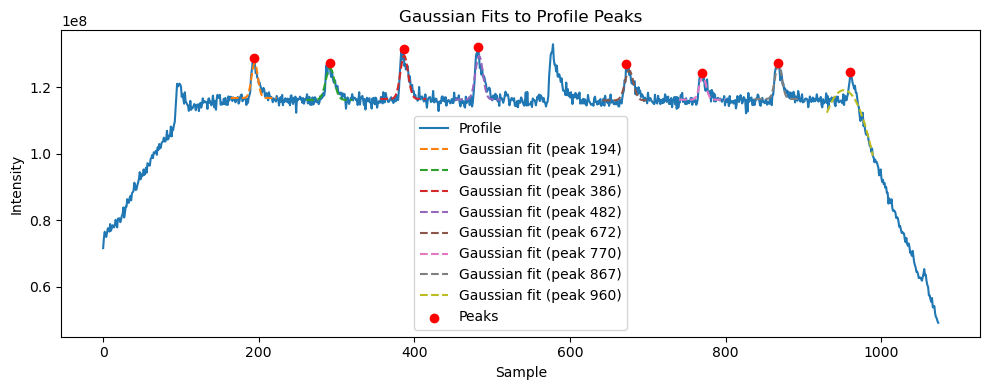

DM = 66.18033988749895  ; score = -196.2345564052599


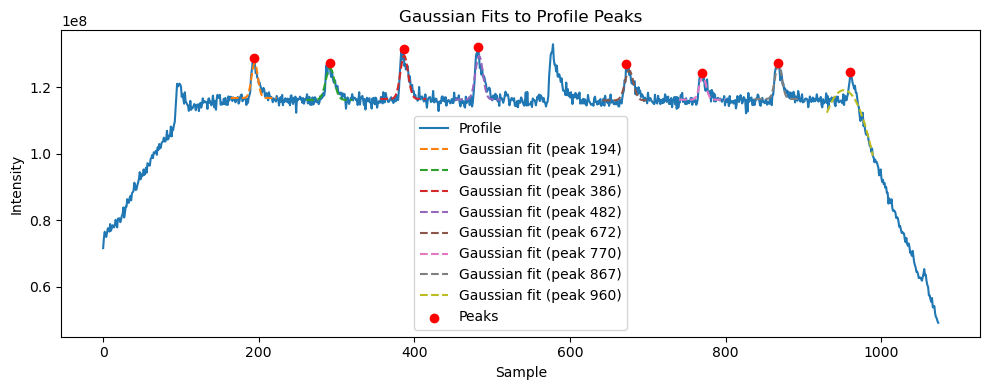

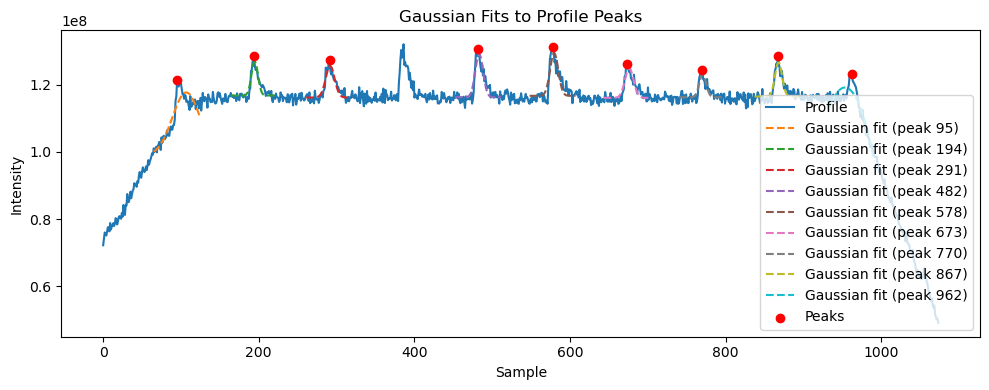

DM = 65.84700557255253  ; score = -89.6035172368575


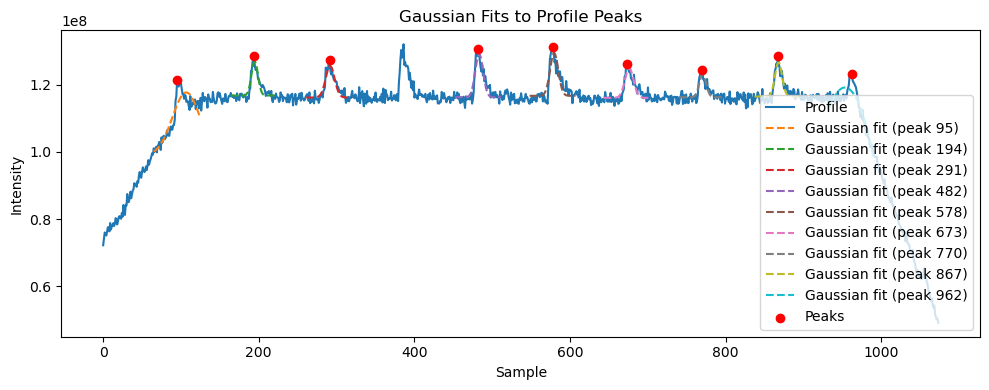

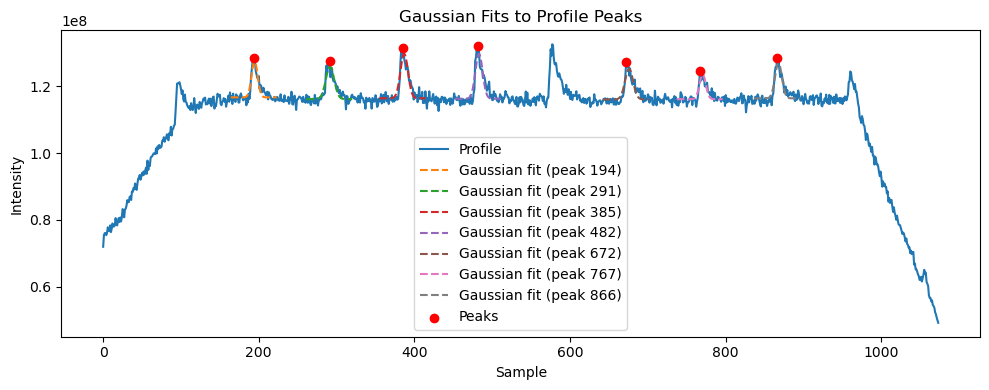

DM = 66.51367420244536  ; score = -4.598679398051078


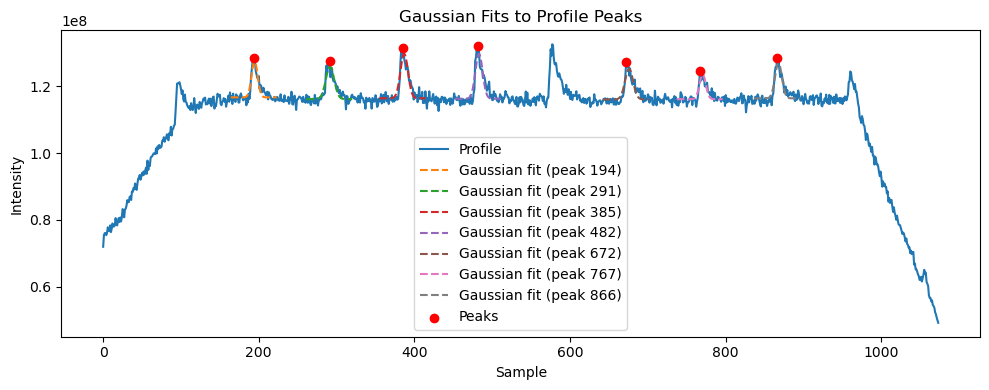

 message: Solution found.
 success: True
  status: 0
     fun: -196.2345564052599
       x: 66.18033988749895
     nit: 5
    nfev: 5
66.18033988749895 196.2345564052599


In [17]:
sample_rate=33e6
block_size=512
avg_blocks=60
freqs=np.linspace(326.5 + 8.25, 326.5 - 8.25, 256)
matrix=vela.intensity_matrix_ch_s[1]

x , y = find_best_dm(matrix, freqs, sample_rate, block_size, avg_blocks, dm_min=65, dm_max=70, tol=1)

print(x,y)

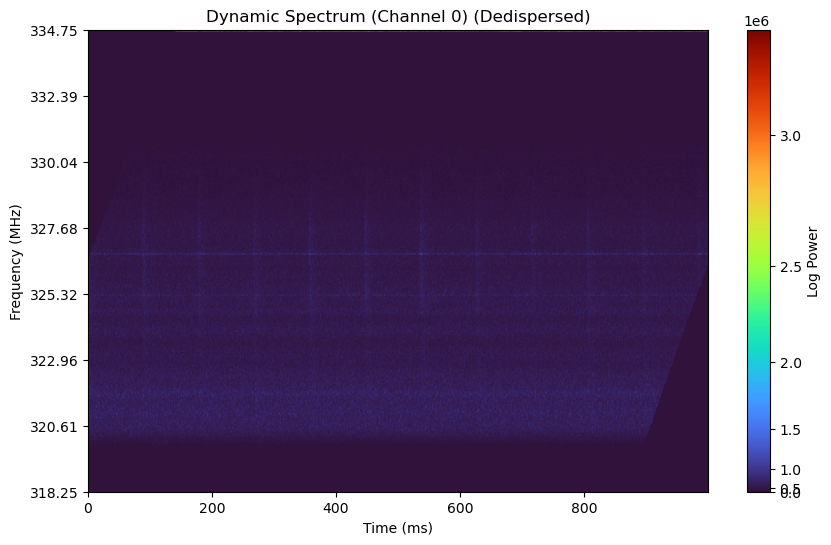

In [37]:
vela.Manual_dedisperse(0,69)
plot_intensity_matrix(vela,channel = 0,dedispersed=True)

In [38]:
plot_intensity_matrix(vela,channel = 2,dedispersed=True)

ValueError: Requested intensity / Desispersed matrix not computed.

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors


from scipy.signal import welch, correlate, find_peaks
from scipy import stats
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize_scalar


def compute_channel_intensity_matrix(channel_data,block_size, avg_blocks, sample_rate):
    total_samples = len(channel_data)
    segment_length = block_size * avg_blocks
    num_segments = total_samples // segment_length
    trimmed = channel_data[:num_segments * segment_length]
    reshaped = trimmed.reshape(num_segments * avg_blocks, block_size)
    fft_data = np.fft.rfft(reshaped, axis=1)  # Use rfft for real inputs
    power_spectra = np.abs(fft_data) ** 2
    power_avg = power_spectra.reshape(num_segments, avg_blocks, -1).mean(axis=1)
    return power_avg

# computing De dispersion

def dedisperse(matrix, DM,block_size, avg_blocks , sample_rate , bandwidth_MHZ = 16.5,center_freq_MHZ = 326.5):

    """
    Dedisperse intensity matrix using cold plasma dispersion delay.
    DM is in pc/cm^3 should be DM=67.8 for vela
    """

    n_time, n_freq = matrix.shape
    #print(matrix.shape)

    # # Generate frequency array for each channel
    bandwidth = bandwidth_MHZ /1000 # MHz to GHz
    center_freq = center_freq_MHZ / 1000 # MHz to GHz

    freq_array = np.linspace(center_freq - bandwidth / 2, center_freq + bandwidth / 2, n_freq)


    # Reference frequency (earliest arrival): highest frequency
    f_ref = freq_array[len(freq_array)//2]

    # Calculate delay in microseconds for each frequency channel
    delays_ms = 4.15 * DM * (1 / freq_array**2 - 1 / f_ref**2)  # in ms
    #delays_s = delays_ms  / 1000  # to Sec


    # # Time bin duration (microseconds per row)
    t_bin =  avg_blocks * block_size / sample_rate * 1000 # in mili Sec
    #print( "Time bin",t_bin)

    delay_bins = (delays_ms / t_bin).astype(int)
    
    # # Initialize dedispersed matrix
    dedispersed = np.zeros_like(matrix)

    for i in range(n_freq):
        shift = delay_bins[i]
        dedispersed[:, i] = np.roll(matrix[:, i], shift)
        if shift > 0 :
            dedispersed[:abs(shift),i] = 0
        elif shift < 0:
            dedispersed[shift:,i] = 0

    return dedispersed


def sharpness_score(matrix):
    profile = matrix.sum(axis=1)
    distance = int(pulseperiod / t_bin_ms  * 0.7 ) 
    width=( int(pulseperiod / t_bin_ms * 0.1) , int(pulseperiod / t_bin_ms * 0.5 ))
    Peeks  = 10
    return -fit_multiple_gaussians(profile,num_peaks = Peeks,distance=distance,width=width)  # Lower sigma → better alignment

def find_best_dm(matrix, sample_rate, block_size, avg_blocks,
                 dm_min=0, dm_max=100, tol=1):

    def objective(dm):
        dedispersed = dedisperse_matrix(matrix, dm, block_size, avg_blocks, sample_rate)

        print(f"DM = {dm}  ; score = {sharpness_score(dedispersed)}")
        #plot_intensity_matrix(dedisperse_matrix(matrix, dm, block_size, avg_blocks , sample_rate), block_size, avg_blocks , sample_rate,gamma=2.5)

        return sharpness_score(dedispersed)

    result = minimize_scalar(objective, bounds=(dm_min, dm_max), method='bounded', options={'xatol': tol})
    print(result)
    return result.x, -result.fun



def gaussian(x, a, mu, sigma, c):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2)) + c

def fit_multiple_gaussians(profile, num_peaks=11, distance=15, width=(5, 100)):
    peaks, _ = find_peaks(profile, distance=distance, width=width)
    peaks = peaks[:num_peaks]
    sigmas = []

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 4))
    plt.plot(profile, label='Profile')
    x_full = np.arange(len(profile))

    for peak in peaks:
        try:
            x = np.arange(peak - 30, peak + 30)
            x = x[(x >= 0) & (x < len(profile))]
            y = profile[x]
            p0 = [np.max(y), peak, 10, np.median(profile)]
            popt, _ = curve_fit(gaussian, x, y, p0=p0)
            sigmas.append(abs(popt[2]))
            plt.plot(x, gaussian(x, *popt), '--', label=f'Gaussian fit (peak {peak})')
        except Exception as e:
            continue

    plt.scatter(peaks, profile[peaks], color='red', zorder=5, label='Peaks')
    plt.legend()
    plt.title('Gaussian Fits to Profile Peaks')
    plt.xlabel('Sample')
    plt.ylabel('Intensity')
    plt.tight_layout()
    plt.show()

    return np.mean(sigmas) if sigmas else np.inf




67 (9, 48)
1074


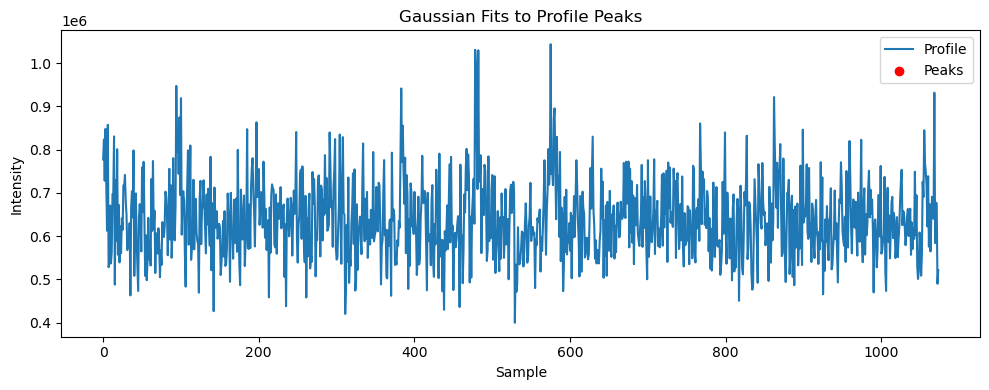

DM = 38.19660112501051  ; score = -inf
67 (9, 48)
1074


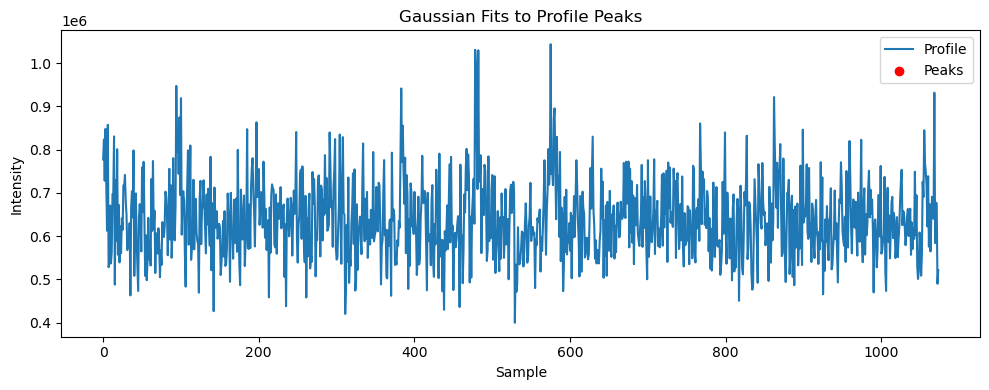

DM = 61.80339887498948  ; score = -inf
67 (9, 48)
1074


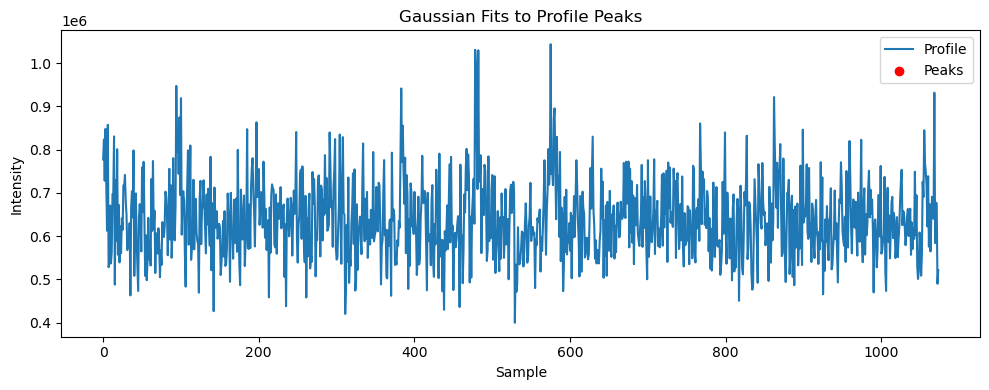

DM = 76.39320225002103  ; score = -inf
67 (9, 48)
1074


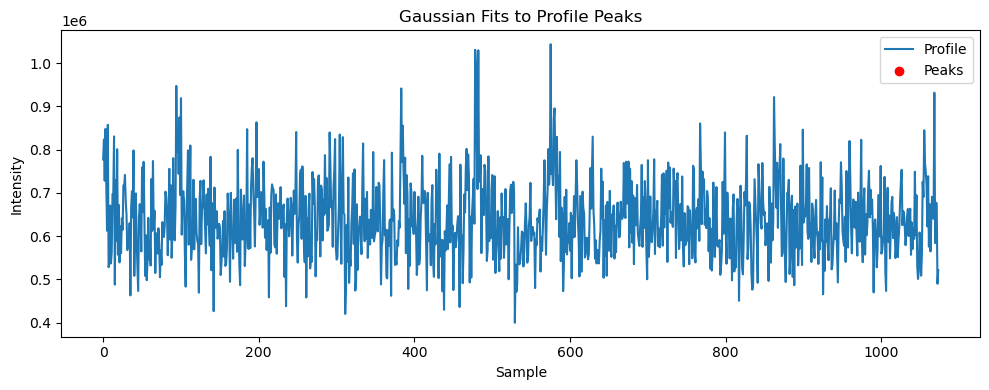

DM = 85.41019662496845  ; score = -inf
67 (9, 48)
1074


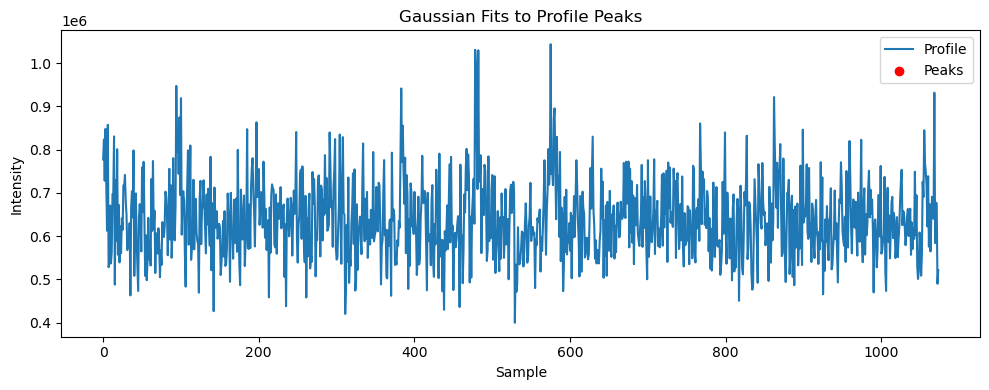

DM = 90.98300562505257  ; score = -inf
67 (9, 48)
1074


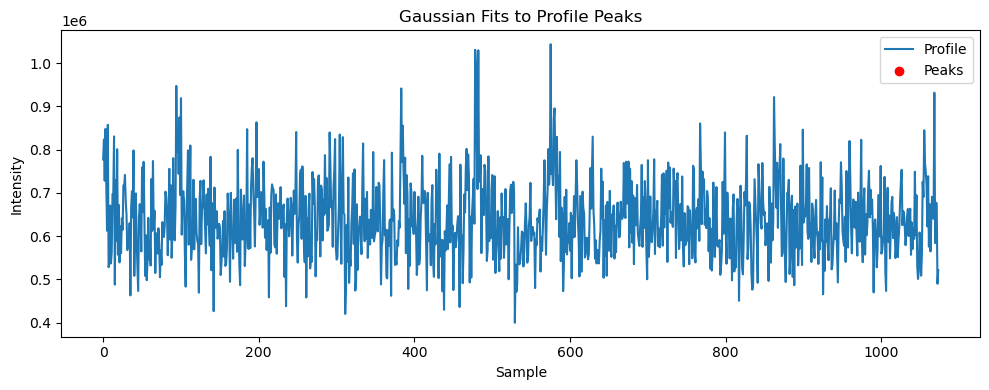

DM = 94.42719099991588  ; score = -inf
67 (9, 48)
1074


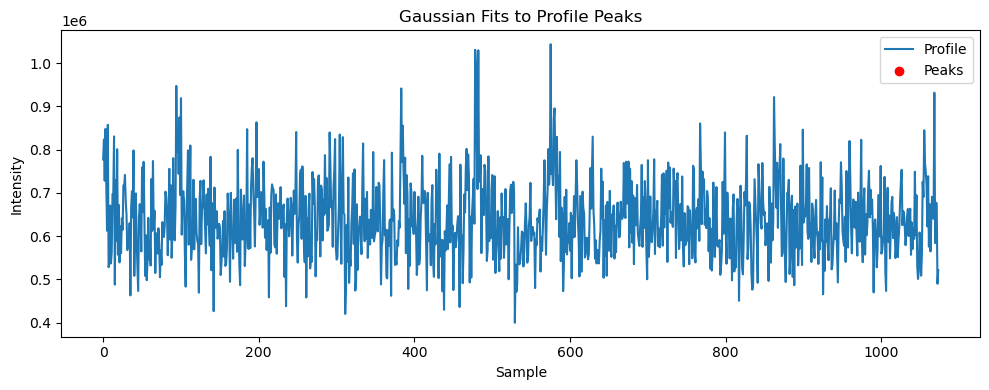

DM = 96.55581462513669  ; score = -inf
67 (9, 48)
1074


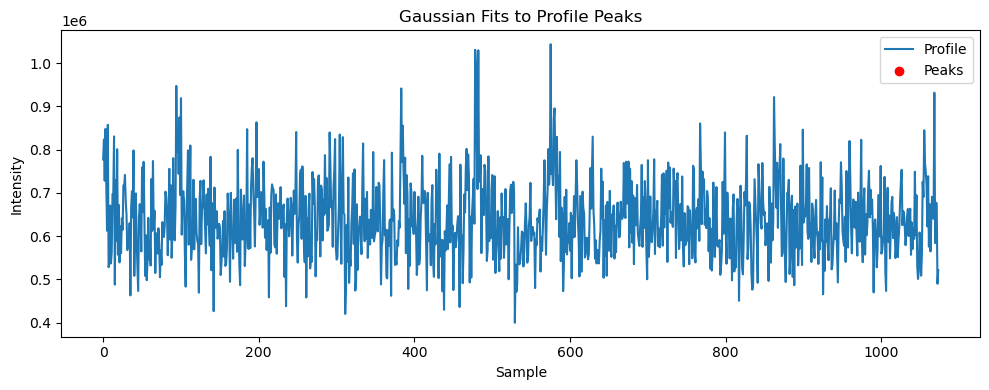

DM = 97.87137637477917  ; score = -inf
67 (9, 48)
1074


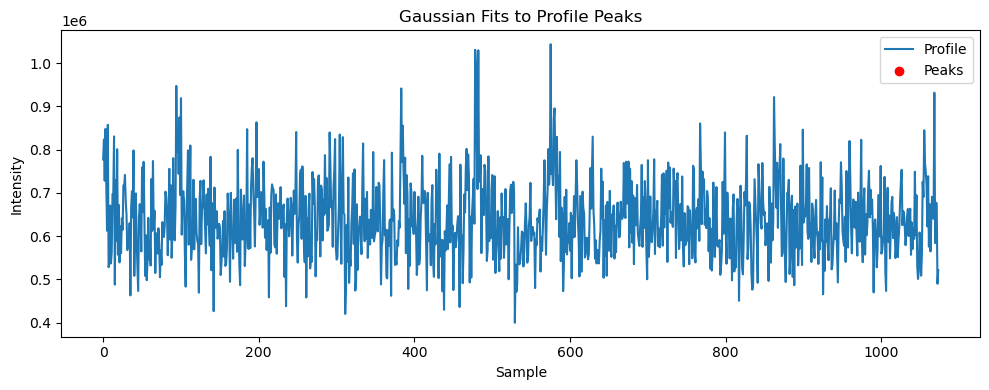

DM = 98.68443825035752  ; score = -inf
67 (9, 48)
1074


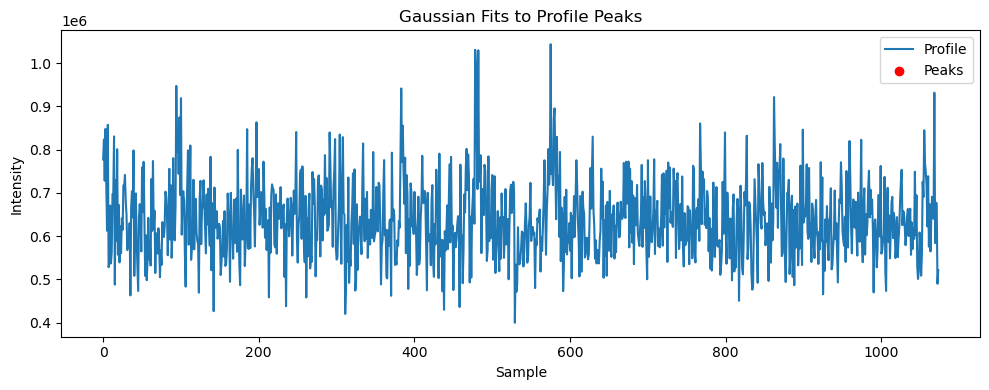

DM = 99.18693812442166  ; score = -inf
67 (9, 48)
1074


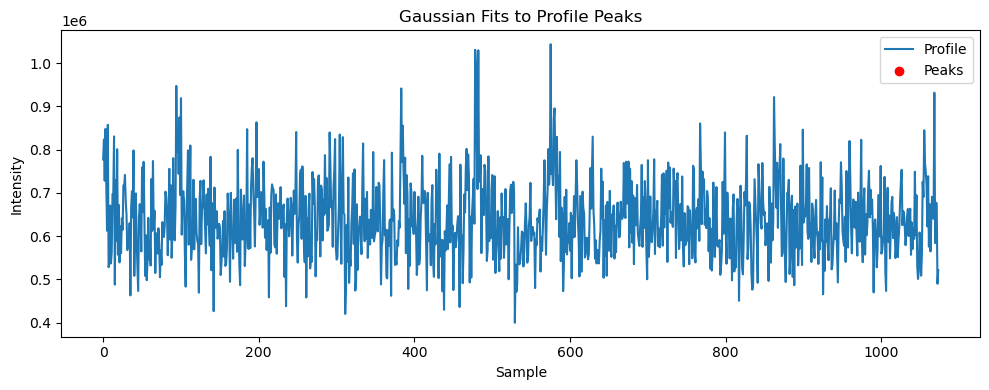

DM = 99.52027292893503  ; score = -inf
99.52027292893503 inf


In [47]:
sample_rate=33e6
block_size=512
avg_blocks=60
freqs=np.linspace(326.5 + 8.25, 326.5 - 8.25, 256)
matrix=vela.intensity_matrix_ch_s[1]
center_freq_MHZ = vela.center_freq_MHZ
bandwidth_MHZ = vela.bandwidth_MHZ
Npeaks = 10
pulseperiod_ms = 90

x , y = find_best_dm(matrix, center_freq_MHZ,bandwidth_MHZ, sample_rate, block_size, avg_blocks,Npeaks,pulseperiod_ms, to_plot, dm_min=0, dm_max=100, tol=1)

print(x,y)

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit, minimize_scalar

def gaussian(self, x, a, mu, sigma, c):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2)) + c

def fit_multiple_gaussians(self, profile, num_peaks=10, distance=15, width=(5, 100), to_plot=False):
    peaks, _ = find_peaks(profile, distance=distance, width=width)
    peaks = peaks[:num_peaks]
    sigmas = []

    if to_plot:
        plt.figure(figsize=(10, 4))
        plt.plot(profile, label='Profile')

    for peak in peaks:
        try:
            x = np.arange(peak - 30, peak + 30)
            x = x[(x >= 0) & (x < len(profile))]
            y = profile[x]
            p0 = [np.max(y), peak, 10, np.median(profile)]
            popt, _ = curve_fit(self.gaussian, x, y, p0=p0)
            sigmas.append(abs(popt[2]))
            if to_plot:
                plt.plot(x, self.gaussian(x, *popt), '--', label=f'Fit (peak {peak})')
        except Exception:
            continue

    if to_plot:
        plt.scatter(peaks, profile[peaks], color='red', zorder=5, label='Peaks')
        plt.legend()
        plt.title('Gaussian Fits to Profile Peaks')
        plt.xlabel('Sample')
        plt.ylabel('Intensity')
        plt.tight_layout()
        plt.show()

    return np.mean(sigmas) if sigmas else np.inf

def sharpness_score(self, matrix, to_plot=False):
    profile = matrix.sum(axis=1)
    t_bin_ms = self.block_size / self.sample_rate * 1000  # sample duration in ms
    if self.pulseperiod_ms is None:
        raise ValueError("pulseperiod_ms is not set in the class.")

    distance = int(self.pulseperiod_ms / t_bin_ms * 0.7)
    width = (
        int(self.pulseperiod_ms / t_bin_ms * 0.1),
        int(self.pulseperiod_ms / t_bin_ms * 0.5)
    )
    return -self.fit_multiple_gaussians(profile, num_peaks=10, distance=distance, width=width, to_plot=to_plot)

def dedisperse_matrix(self, matrix, DM):
    return dedisperse(
        matrix, DM,
        block_size=self.block_size,
        avg_blocks=self.avg_blocks,
        sample_rate=self.sample_rate,
        bandwidth_MHZ=self.bandwidth_MHZ,
        center_freq_MHZ=self.center_freq_MHZ
    )

def find_best_dm(self, matrix, dm_min=0, dm_max=100, tol=1, to_plot=False):
    def objective(dm):
        dedispersed = self.dedisperse_matrix(matrix, dm)
        score = self.sharpness_score(dedispersed, to_plot=False)
        print(f"DM = {dm:.2f}  ; Score = {score:.3f}")
        return score

    result = minimize_scalar(objective, bounds=(dm_min, dm_max), method='bounded', options={'xatol': tol})
    print(result)
    return result.x, -result.fun

def Auto_dedisperse(self, channel, dm_min=0, dm_max=100, to_plot=False):
    matrix = self.intensity_matrix_ch_s[channel]

    best_dm, score = self.find_best_dm(matrix, dm_min=dm_min, dm_max=dm_max, to_plot=to_plot)
    self.dedispersion_measure = best_dm

    dedispersed = self.dedisperse_matrix(matrix, best_dm)
    self.dedispersed_ch_s[channel] = dedispersed

    if to_plot:
        profile = dedispersed.sum(axis=1)
        self.sharpness_score(dedispersed, to_plot=True)


In [50]:
Auto_dedisperse(vela,1, dm_min=50, dm_max=70, to_plot=True)

AttributeError: 'PulsarDataFile' object has no attribute 'find_best_dm'